In [243]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
import numpy as np

In [244]:
purchases = pd.read_csv(r'C:\Users\Honor\Downloads\Проект_4_purchases.csv')

In [245]:
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [246]:
groups = pd.read_csv(r'C:\Users\Honor\Downloads\Проект_4_groups.csv')

In [247]:
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [248]:
active_users = pd.read_csv(r'C:\Users\Honor\Downloads\Проект_4_active_users.csv')

In [249]:
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [250]:
ab_test = active_users.merge(groups, on='user_id') \
            .merge(purchases, on='user_id', how='left') \
            .fillna(0)
ab_test.head()

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0.0
1,1735,Sweden,ios,male,B,0.0
2,7697,Russia,android,male,B,0.0
3,1421,Sweden,android,female,B,0.0
4,1704,Russia,ios,male,B,0.0


In [251]:
ab_test.to_csv(r'C:\Users\Honor\Downloads\AB.csv', encoding='utf-8', index=False)

# Для сравнения двух групп были выбраны метрики ARPU, ARPPU,
# CR(конверсия посещения приложения в покупку)

выбор этих метрик обоснован тем, что ключевой показатель, на который нацелен эксперимент - выручка(revenue)

In [252]:
ARPU_A = ab_test.query('group=="A"') \
        .revenue.mean()
ARPU_A

47.853055916775034

In [253]:
ARPU_B = ab_test.query('group=="B"') \
        .revenue.mean()
ARPU_B

58.520211671321476

In [254]:
ARPPU_A = ab_test.query('group=="A" & revenue > 0').revenue.sum() \
            / ab_test.query('group=="A" & revenue > 0').user_id.count()
ARPPU_A

943.5641025641025

In [255]:
ARPPU_B = ab_test.query('group=="B" & revenue > 0').revenue.sum() \
            / ab_test.query('group=="B" & revenue > 0').user_id.count()
ARPPU_B

1267.875796178344

In [256]:
CR_A = ab_test.query('group=="A" & revenue > 0').user_id.count() \
                / ab_test.query('group=="A"').user_id.count()
CR_A

0.05071521456436931

In [257]:
CR_B = ab_test.query('group=="B" & revenue > 0').user_id.count() \
                / ab_test.query('group=="B"').user_id.count()
CR_B

0.046156107599588415

# Проверка на равномерное распределение юзеров
# по платформам, странам и полу

In [258]:
pd.crosstab(ab_test.group, ab_test.platform)

platform,android,ios
group,,
A,834,704
B,3787,3016


In [259]:
pd.crosstab(ab_test.group, ab_test.sex)

sex,female,male
group,,
A,753,785
B,3392,3411


In [260]:
pd.crosstab(ab_test.group, ab_test.country)

country,Russia,Sweden
group,,
A,915,623
B,4492,2311


По распределению видно, что по отдельным критериям группы распределены примерно равномерно

# Проверка на нормальность распределения выборок

C:\Users\Honor\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

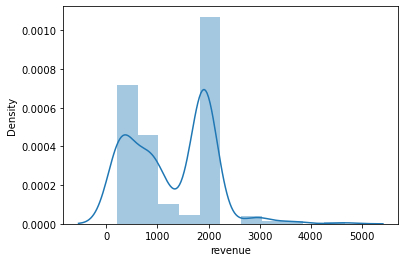

In [261]:
sns.distplot(ab_test.query('group=="B" & revenue > 0').revenue)

C:\Users\Honor\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

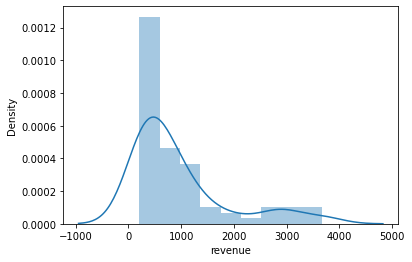

In [262]:
sns.distplot(ab_test.query('group=="A" & revenue > 0').revenue)

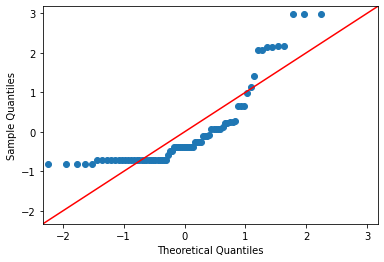

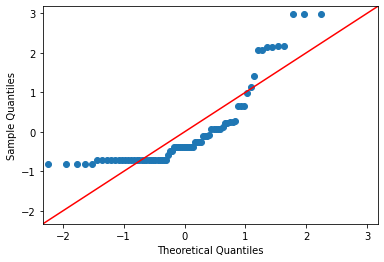

In [263]:
sm.qqplot(ab_test.query('group=="A" & revenue > 0').revenue, line='45', fit=True)

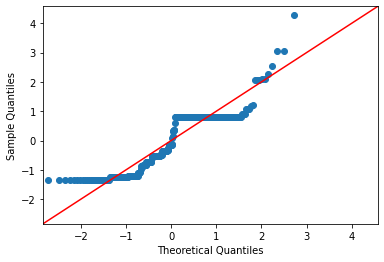

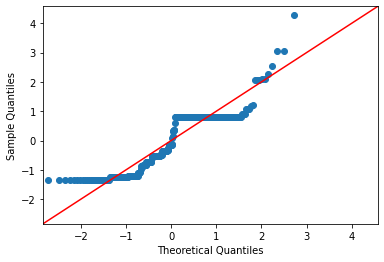

In [264]:
sm.qqplot(ab_test.query('group=="B" & revenue > 0').revenue, line='45', fit=True)

# Т.к. выборки распределены не нормально, применяется метод Манна-Уитни.
# Сравниваются чеки юзеров, которые совершили покупку

In [265]:
a = ab_test.query('group=="A" & revenue>0').revenue
b = ab_test.query('group=="B" & revenue>0').revenue

In [266]:
st.mannwhitneyu(a, b)
# По результатам теста можно сказать, что средние чеки платящих юзеров в группах значимо различаются.
# Новая модель оплаты, с определенной вер-ю, побуждает юзеров покупать более дорогие или больше шаблонов для сторис.

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

# Сравниваем средние чеки среди всех активных юзеров

Данные так же распределены не нормально, поэтому применяем Манна-Уитни

In [267]:
a = ab_test.query('group=="A"').revenue
b = ab_test.query('group=="B"').revenue

In [268]:
st.mannwhitneyu(a, b)
# Статистически значимых различий между двумя группами нет.
# Различие средних чеков среди всех активных юзеров вызвано лишь различиями среди платящих юзеров,
# что было показано в предыдущем тесте (средний чек пользователя, совершившего покупку стат. значимо вырос)

MannwhitneyuResult(statistic=5252073.0, pvalue=0.5107994153653242)

Таким образом, можно сделать вывод, что новая модель оплаты стат. значимо увеличивает средний чек платящего пользователя
и ее стоит выкатывать на всех юзеров.